In [4]:
import blosc2
import numpy as np
import archetypes as arch

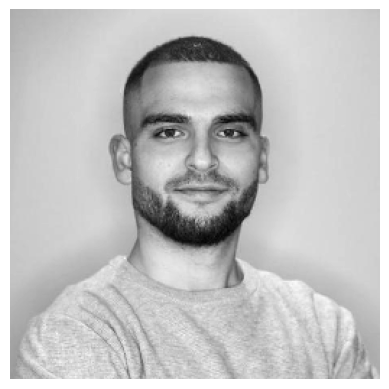

In [5]:
import cv2

img = cv2.imread("C:/Users/aalcacer/Projects/biaa-codec/profile.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC).astype(np.float64)

import matplotlib.pyplot as plt

plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()


In [6]:
tile_shape = np.array([4, 4])

img_tiled = img.reshape(img.shape[0] // tile_shape[0], tile_shape[0], img.shape[1] // tile_shape[1], tile_shape[1])
img_tiled = img_tiled.transpose(0, 2, 1, 3).reshape(-1, tile_shape.prod())

# Compte archetypes
k = 16

model = arch.AA(k, max_iter=1_000, tol=1e-6, verbose=True)
img_sampled = img_tiled[np.random.choice(img_tiled.shape[0], 1_000, replace=False)]
model.fit(img_sampled)

archetypes = model.archetypes_

Initialization 1/1
    Iteration:    1, RSS: inf
    Iteration:  101, RSS: 1148.60
    Iteration:  201, RSS: 832.36
    Iteration:  301, RSS: 801.36
    Iteration:  401, RSS: 797.81
    Iteration:  501, RSS: 796.65
    Iteration:  601, RSS: 796.27
    Iteration:  701, RSS: 796.17
    Iteration:  801, RSS: 796.14
    Iteration:  901, RSS: 796.13


1401.7824460581862

In [ ]:
# Create an User-defined codec (just a memcpy)

import lz4

def encoderBiAA(input, output, meta, schunk: blosc2.SChunk):
    shape = (meta, meta)
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    block_edge = int(np.sqrt(schunk.blocksize / itemsize))
    shape = (block_edge, block_edge)
    img = np.frombuffer(input[:schunk.blocksize], dtype=dtype).reshape(shape)

    # apply biaa
    model = arch.BiAA(n_archetypes=(3, 3), max_iter=1000, random_state=0, n_init=10, tol=1e-16)
    model.fit(img)

    # save archetypes
    archetypes = model.archetypes_
    alphas, gammas = model.transform(img)

    archetypes_shape = np.array(archetypes.shape, dtype=np.uint32)
    alphas_shape = np.array(alphas.shape, dtype=np.uint32)
    gammas_shape = np.array(gammas.shape, dtype=np.uint32)


    # Serialize archetypes info
    output_start = 0
    output_stop = archetypes_shape.nbytes
    output[output_start:output_stop] = archetypes_shape.view(np.uint8).reshape(-1)
    
    output_start = output_stop
    output_stop += archetypes.nbytes
    output[output_start:output_stop] = archetypes.view(np.uint8).reshape(-1)
    
    # Serialize alphas info
    output_start = output_stop
    output_stop += alphas_shape.nbytes
    output[output_start:output_stop] = alphas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += alphas.nbytes
    output[output_start:output_stop] = alphas.view(np.uint8).reshape(-1)

    # Serialize gammas info
    output_start = output_stop
    output_stop += gammas_shape.nbytes
    output[output_start:output_stop] = gammas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += gammas.nbytes
    output[output_start:output_stop] = gammas.view(np.uint8).reshape(-1)

    # compress output
    output_compresed = lz4.frame.compress(output[:output_stop], compression_level=16)
    output_compresed_size = len(output_compresed)

    # copy compressed size to output
    output_start = 0
    output_stop = 4
    output[output_start:output_stop] = np.array(output_compresed_size, dtype=np.uint32).view(np.uint8).reshape(-1)

    # copy compressed data to output
    output_start = output_stop
    output_stop += output_compresed_size
    output[output_start:output_stop] = output_compresed
    
    return output_stop

In [ ]:
def decoderBiAA(input, output, meta, schunk: blosc2.SChunk):
    # get compressed size
    compressed_size = np.frombuffer(input[:4], dtype=np.uint32)[0]

    # decompress input
    input_start = 4
    input_stop = input_start + compressed_size
    input = lz4.frame.decompress(input[input_start:input_stop])

    # get archetypes info

    input_start = 0
    input_stop = 8
    archetypes_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += archetypes_shape.prod() * itemsize
    archetypes = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(archetypes_shape)

    input_start = input_stop
    input_stop += 8
    alphas_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += alphas_shape.prod() * itemsize
    alphas = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(alphas_shape)

    input_start = input_stop
    input_stop += 8
    gammas_shape = np.frombuffer(input[input_start:input_stop], dtype=np.uint32)

    input_start = input_stop
    input_stop += gammas_shape.prod() * itemsize
    gammas = np.frombuffer(input[input_start:input_stop], dtype=dtype).reshape(gammas_shape)

    img = alphas @ archetypes @ gammas
  
    output[:schunk.blocksize] = img.view(np.uint8).reshape(-1)

    return schunk.blocksize


In [ ]:

# Register the codec
codec_id = 213
# blosc2.register_codec('BiAA', codec_id, encoderBiAA, decoderBiAA)

In [7]:
# Create an User-defined codec (just a memcpy)
import pywt
from skimage.metrics import structural_similarity as ssim

def encoderAA(input, output, meta, schunk: blosc2.SChunk):
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    block_size = int(np.sqrt(schunk.blocksize / itemsize))
    shape = (block_size, block_size)
    img = input.view(dtype=dtype).reshape(shape)

    # convert img to a 3D array with tiles of size 4x4
    tile_size = 4
    img_org = img.copy()

    img = img.reshape((block_size//tile_size, tile_size, block_size//tile_size, tile_size))
    img = img.transpose((0, 2, 1, 3))
    img = img.reshape((block_size//tile_size, block_size//tile_size, tile_size*tile_size))
    img = img.reshape(-1, tile_size * tile_size)

    # apply aa

    k = 3
    while True:
        model = arch.AA(n_archetypes=k, max_iter=100, random_state=0, n_init=1)
        model.fit(img)
        img_reconstructed = model.transform(img) @ model.archetypes_
        img_reconstructed = img_reconstructed.reshape((block_size//tile_size, block_size//tile_size, tile_size, tile_size))
        img_reconstructed = img_reconstructed.transpose((0, 2, 1, 3))
        img_reconstructed = img_reconstructed.reshape((block_size, block_size))

        s = ssim(img_org, img_reconstructed, data_range=img_org.max() - img_org.min())
        if s > 0.95 or k == 15:
            break
        k += 1

    # save archetypes
    archetypes = model.archetypes_
    alphas = model.transform(img)
    # for i in range(alphas.shape[0]):
        # alphas[i] = pywt.threshold(alphas[i], 0.1, mode='hard', substitute=0)
        # alphas[i] /= alphas[i].sum()

    archetypes_shape = np.array(archetypes.shape, dtype=np.uint32)
    alphas_shape = np.array(alphas.shape, dtype=np.uint32)

    # Serialize archetypes info
    output_start = 0
    output_stop = archetypes_shape.nbytes
    output[output_start:output_stop] = archetypes_shape.view(np.uint8).reshape(-1)
    
    output_start = output_stop
    output_stop += archetypes.nbytes
    output[output_start:output_stop] = archetypes.view(np.uint8).reshape(-1)
    
    # Serialize alphas info
    output_start = output_stop
    output_stop += alphas_shape.nbytes
    output[output_start:output_stop] = alphas_shape.view(np.uint8).reshape(-1)

    output_start = output_stop
    output_stop += alphas.nbytes
    output[output_start:output_stop] = alphas.view(np.uint8).reshape(-1)

    # compress output
    output_compresed = lz4.frame.compress(output[:output_stop], compression_level=16)
    output_compresed_size = len(output_compresed)

    # copy compressed size to output
    output_start = 0
    output_stop = 4
    output[output_start:output_stop] = np.array([output_compresed_size], dtype=np.uint32).view(np.uint8).reshape(-1)

    # copy compressed data to output
    output_start = output_stop
    output_stop += output_compresed_size
    output[output_start:output_stop] = np.frombuffer(output_compresed, dtype=np.uint8).reshape(-1)
    return output_stop

In [8]:
def decoderAA(input, output, meta, schunk: blosc2.SChunk):
    # get compressed size
    compressed_size = np.frombuffer(input[:4], dtype=np.uint32)[0]

    # decompress input
    input_start = 4
    input_stop = input_start + compressed_size
    input = lz4.frame.decompress(input[input_start:input_stop])
    input = np.frombuffer(input, dtype=np.uint8)
    
    tile_size = 4
    dtype = np.dtype(np.float64)
    itemsize = dtype.itemsize
    blockedge_size = int(np.sqrt(schunk.blocksize / itemsize))

    input_start = 0
    input_stop = 8
    archetypes_shape = input[input_start:input_stop].view(np.uint32)

    input_start = input_stop
    input_stop += archetypes_shape.prod() * itemsize
    archetypes = input[input_start:input_stop].view(dtype).reshape(archetypes_shape)

    input_start = input_stop
    input_stop += 8
    alphas_shape = input[input_start:input_stop].view(np.uint32)

    input_start = input_stop
    input_stop += alphas_shape.prod() * itemsize
    alphas = input[input_start:input_stop].view(dtype).reshape(alphas_shape)

    img = alphas @ archetypes
    
    img = img.reshape((blockedge_size//tile_size, blockedge_size//tile_size, tile_size, tile_size))
    img = img.transpose((0, 2, 1, 3))
    img = img.reshape((blockedge_size, blockedge_size))
  
    output[:schunk.blocksize] = img.view(np.uint8).reshape(-1)

    return schunk.blocksize


In [9]:
codec_id = 222
blosc2.register_codec('AA', codec_id, encoderAA, decoderAA)

NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


KeyboardInterrupt: 

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 26, in encoderAA
  File "c:\Users\aalcacer\Miniconda3\envs\biaa-codec\lib\site-packages\archetypes\algorithms\archetypes.py", line 184, in fit
    alphas, betas, rss, Z, n_iter = _aa_simple(
  File "c:\Users\aalcacer\Miniconda3\envs\biaa-codec\lib\site-packages\archetypes\algorithms\archetypes.py", line 37, in _aa_simple
    alphas = _optimize_alphas(X, Z)
  File "c:\Users\aalcacer\Miniconda3\envs\biaa-codec\lib\site-packages\archetypes\algorithms\archetypes.py", line 17, in _optimize_alphas
    alphas /= alphas.sum(1)[:, None]
  File "c:\Users\aalcacer\Miniconda3\envs\biaa-codec\lib\site-packages\numpy\core\_methods.py", line 49, in _sum
    return umr_sum(a, axis, dtype, out, keepdims, initial, where)
KeyboardInterrupt: 


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


NameError: name 'lz4' is not defined

Exception ignored in: 'blosc2.blosc2_ext.general_encoder'
Traceback (most recent call last):
  File "C:\Users\aalcacer\AppData\Local\Temp\ipykernel_7508\1692116459.py", line 66, in encoderAA
NameError: name 'lz4' is not defined


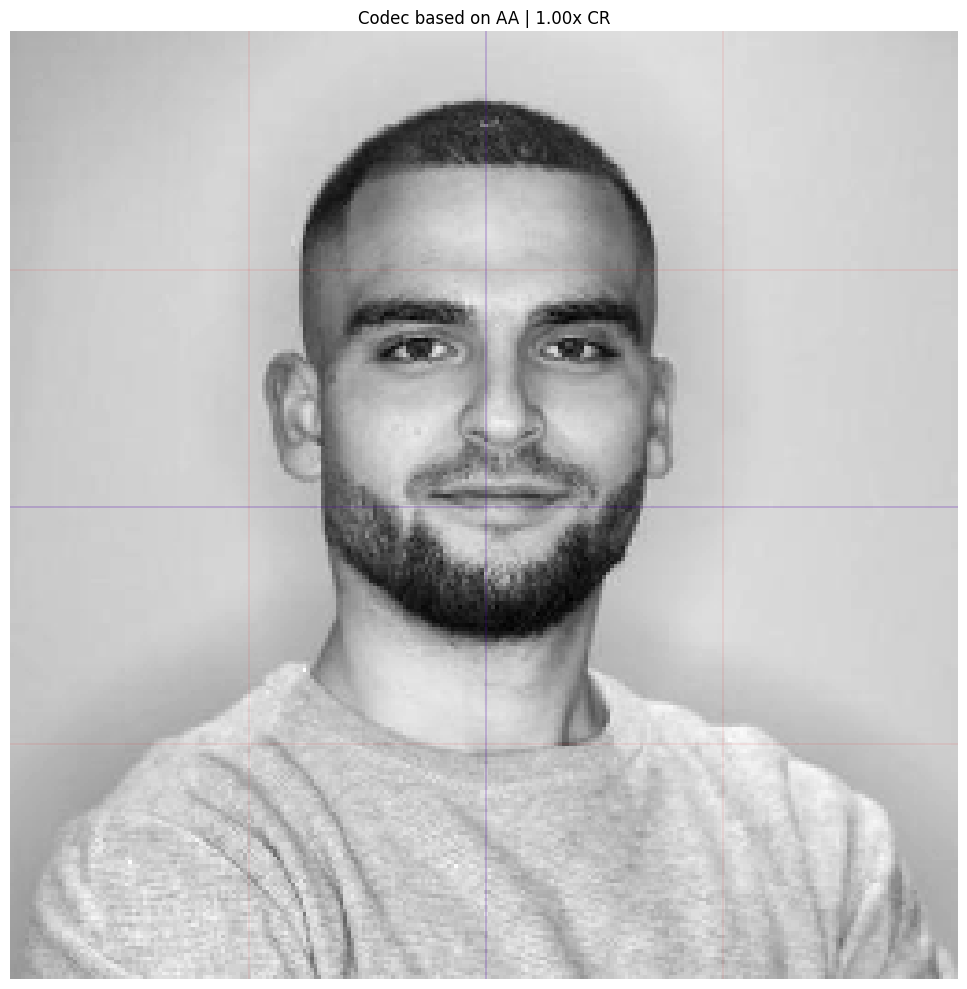

In [12]:

chunks = (128, 128)
blocks = (64, 64)

cparams = {
    'codec': codec_id,
    'codec_meta': 0,
    'nthreads': 1,
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}

dparams = {
    'nthreads': 1,
}

# Create a subplot with 2 rows and 3 columns
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

fax = [ax]

for i in range(len(fax)):
    # cparams['codec_meta'] = k
    c_img = blosc2.asarray(img, chunks=chunks, blocks=blocks, cparams=cparams, dparams=dparams, meta={'arch': bytes(np.ones((16, 16)))})
    
    fax[i].imshow(c_img[:], cmap="gray")
    fax[i].axis('off')
    fax[i].set_title(f"Codec based on AA | {c_img.schunk.cratio:.2f}x CR")

    for j in range(blocks[0], img.shape[0], blocks[0]):
        fax[i].axhline(j, color='red', lw=.1)
    for j in range(blocks[1], img.shape[1], blocks[1]):
        fax[i].axvline(j, color='red', lw=.1)

    for j in range(chunks[0], img.shape[0], chunks[0]):
        fax[i].axhline(j, color='blue', lw=.2)
    for j in range(chunks[1], img.shape[1], chunks[1]):
        fax[i].axvline(j, color='blue', lw=.2)

plt.tight_layout()
plt.show()

In [ ]:
50*50*4

10000

In [ ]:
c_img.schunk.meta["arch"] = bytes(np.ones((16, 16)))

: 

: 

In [ ]:
ones = np.frombuffer(c_img.schunk.vlmeta["arch"], dtype=np.float64).reshape(16, 16)


In [ ]:
ones

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,